<a href="https://colab.research.google.com/github/Namsik-Yoon/pytorch_basic/blob/master/6_1_%ED%95%A9%EC%84%B1%EA%B3%B1_%EC%8B%A0%EA%B2%BD%EB%A7%9D_with_My_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

cifar100데이터를 바탕으로 CNN모델 학습

# Data Visualizing

In [0]:
import matplotlib.pyplot as plt

import torch

import torchvision
import torchvision.datasets 
import torchvision.transforms as transforms

In [2]:
cifar100_data = torchvision.datasets.CIFAR100('data/', download=True)

Extracting data/cifar-100-python.tar.gz to data/


In [16]:
cifar100_data.data[0].shape

(32, 32, 3)

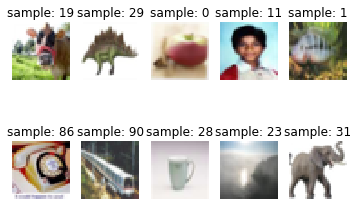

In [3]:
images_and_labels = list(zip(cifar100_data.data, cifar100_data.targets))
for index, (image, label) in enumerate(images_and_labels[:10]): # 10개의 샘플만 출력
    plt.subplot(2, 5, index + 1)
    plt.axis('off')
    plt.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')
    plt.title('sample: %i' % label)

In [4]:
for i in range(10):
  print(i,'번 인덱스 샘플의 레이블 : ',cifar100_data.targets[i])

0 번 인덱스 샘플의 레이블 :  19
1 번 인덱스 샘플의 레이블 :  29
2 번 인덱스 샘플의 레이블 :  0
3 번 인덱스 샘플의 레이블 :  11
4 번 인덱스 샘플의 레이블 :  1
5 번 인덱스 샘플의 레이블 :  86
6 번 인덱스 샘플의 레이블 :  90
7 번 인덱스 샘플의 레이블 :  28
8 번 인덱스 샘플의 레이블 :  23
9 번 인덱스 샘플의 레이블 :  31


# Model1 Building

In [5]:
cifar100_train = torchvision.datasets.CIFAR100(root='cifar100_data/', # 다운로드 경로 지정
                          train=True, # True를 지정하면 훈련 데이터로 다운로드
                          transform=transforms.ToTensor(), # 텐서로 변환
                          download=True)

cifar100_test = torchvision.datasets.CIFAR100(root='cifar100_data/', # 다운로드 경로 지정
                         train=False, # False를 지정하면 테스트 데이터로 다운로드
                         transform=transforms.ToTensor(), # 텐서로 변환
                         download=True)

Extracting cifar100_data/cifar-100-python.tar.gz to cifar100_data/
Files already downloaded and verified


In [0]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

learning_rate = 0.001
epochs = 10
batch_size = 100

In [0]:
train_loader = torch.utils.data.DataLoader(dataset=cifar100_train,
                                          batch_size=batch_size,
                                          shuffle=True,
                                          drop_last=True)

test_loader = torch.utils.data.DataLoader(dataset=cifar100_test,
                                          batch_size=len(cifar100_test))

In [0]:
class CNN(torch.nn.Module):

    def __init__(self):
        super(CNN, self).__init__()
        self.layer1 = torch.nn.Sequential(
            torch.nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2))

        self.layer2 = torch.nn.Sequential(
            torch.nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2))

        # 전결합층 7x7x64 inputs -> 10 outputs
        self.fc = torch.nn.Linear(8 * 8 * 64, 100, bias=True)

        # 전결합층 한정으로 가중치 초기화
        torch.nn.init.xavier_uniform_(self.fc.weight)

    def forward(self, x):
        out = self.layer1(x) # [batch_size, 3, 32, 32] -> [batch_size, 32, 32, 32] -> [batch_size, 32, 16, 16]
        out = self.layer2(out) # [batch_size, 32, 16, 16] -> [batch_size, 64, 16, 16] -> [batch_size, 64, 8, 8]
        out = out.view(out.size(0), -1)   # 전결합층을 위해서 Flatten
        out = self.fc(out)
        return out

In [0]:
model = CNN().to(device)
criterion = torch.nn.CrossEntropyLoss().to(device)    # 비용 함수에 소프트맥스 함수 포함되어져 있음.
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [45]:
total_batch = len(train_loader)
print('총 배치의 수 : {}'.format(total_batch))

총 배치의 수 : 500


In [46]:
plot_list = {'train':[],'val':[],'accuracy':[]}

for epoch in range(epochs):
    model.train()
    train_losses = []
    for X, Y in train_loader: # 미니 배치 단위로 꺼내온다. X는 미니 배치, Y는 레이블.
        # image is already size of (28x28), no reshape
        # label is not one-hot encoded
        X = X.to(device)
        Y = Y.to(device)

        optimizer.zero_grad()
        hypothesis = model(X)
        train_loss = criterion(hypothesis, Y)
        train_loss.backward()
        optimizer.step()

        train_losses.append(train_loss.item())
    
    model.eval()
    val_losses = []
    for i,data in enumerate(test_loader):
        inputs,targets = data[0].to(device), data[1].to(device)

        outputs = model(inputs)
        val_loss = criterion(outputs,targets)
        val_losses.append(val_loss.detach())

        prob,label = torch.exp(outputs).topk(1,dim=1)

    correct = label.view(-1)==targets
    val_accuracy = correct.float().mean()

    print(f"{epoch+1} epoch train loss = {sum(train_losses)/len(train_losses)}")
    print(f"{epoch+1} epoch val loss = {sum(val_losses)/len(val_losses)}")
    print(f"{epoch+1} epoch accuracy = {val_accuracy}")
    print('--------------------------------------------------')
    plot_list['train'].append(sum(train_losses)/len(train_losses))
    plot_list['val'].append(sum(val_losses)/len(val_losses))
    plot_list['accuracy'].append(val_accuracy)

1 epoch train loss = 3.5886573758125304
1 epoch val loss = 3.180762529373169
1 epoch accuracy = 0.24479998648166656
--------------------------------------------------
2 epoch train loss = 2.8788902249336243
2 epoch val loss = 2.8448245525360107
2 epoch accuracy = 0.31450000405311584
--------------------------------------------------
3 epoch train loss = 2.550783606290817
3 epoch val loss = 2.7186319828033447
3 epoch accuracy = 0.3425000011920929
--------------------------------------------------
4 epoch train loss = 2.3160354595184325
4 epoch val loss = 2.6294753551483154
4 epoch accuracy = 0.3637000024318695
--------------------------------------------------
5 epoch train loss = 2.118513953447342
5 epoch val loss = 2.6252024173736572
5 epoch accuracy = 0.37229999899864197
--------------------------------------------------
6 epoch train loss = 1.9443065958023071
6 epoch val loss = 2.645355224609375
6 epoch accuracy = 0.3723999857902527
--------------------------------------------------